# Negative binomial modeling of simulated CRISPR screen data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time
from typing import Union

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from scipy import stats
from theano import tensor as tt

In [3]:
from src.analysis import pymc3_analysis as pmanal
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.globals import PYMC3
from src.io import cache_io
from src.loggers import logger
from src.modeling import pymc3_sampling_api as pmapi
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 1042
np.random.seed(RANDOM_SEED)

sources of simulated NB data:

- [PyMC3 docs: "GLM: Negative Binomial Regression"](https://docs.pymc.io/pymc-examples/examples/generalized_linear_models/GLM-negative-binomial-regression.html)

In [5]:
def get_nb_vals(mu, alpha, size):
    """Generate negative binomially distributed samples by
    drawing a sample from a gamma distribution with mean `mu` and
    shape parameter `alpha', then drawing from a Poisson
    distribution whose rate parameter is given by the sampled
    gamma variable.

    """

    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)

## Simulation 1. Single sgRNA

In [6]:
n = 100  # number simulated data points

# Simulation parameters.
sim1: dict[str, Union[float, np.ndarray]] = {"β": -0.5, "α": 2.0}

# Simulated data.
sim1_data = pd.DataFrame({"initial_read_count": np.random.poisson(100, n)})
sim1_data["initial_read_count_log"] = np.log(sim1_data)
eta = sim1["β"]

mu = np.exp(eta) * sim1_data["initial_read_count"]
sim1_data["final_read_count"] = [
    get_nb_vals(mu[i], sim1["α"], size=1) for i in range(n)
]

sim1_data.head()

,initial_read_count,initial_read_count_log,final_read_count
0,95,4.553877,15
1,110,4.700480,128
2,122,4.804021,37
3,88,4.477337,34
4,124,4.820282,33


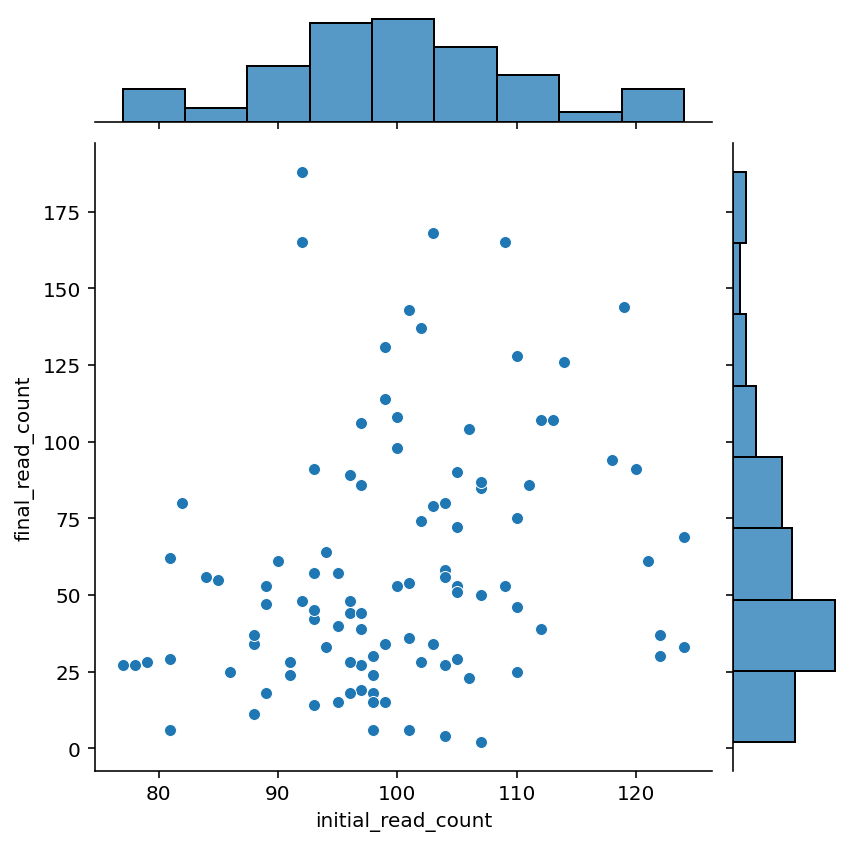

In [18]:
sns.jointplot(data=sim1_data, x="initial_read_count", y="final_read_count");

In [10]:
with pm.Model() as sim1_model:
    β = pm.Normal("β", 0, 2)
    η = pm.Deterministic("η", β)
    μ = pm.Deterministic("μ", pm.math.exp(η) * sim1_data.initial_read_count.values)
    α = pm.HalfNormal("α", 5)
    y = pm.NegativeBinomial("y", μ, α, observed=sim1_data.final_read_count.values)

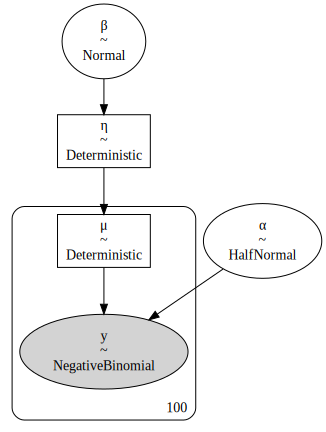

In [11]:
pm.model_to_graphviz(sim1_model)

In [12]:
with sim1_model:
    sim1_trace = pm.sample(tune=2000, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [α, β]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 29 seconds.


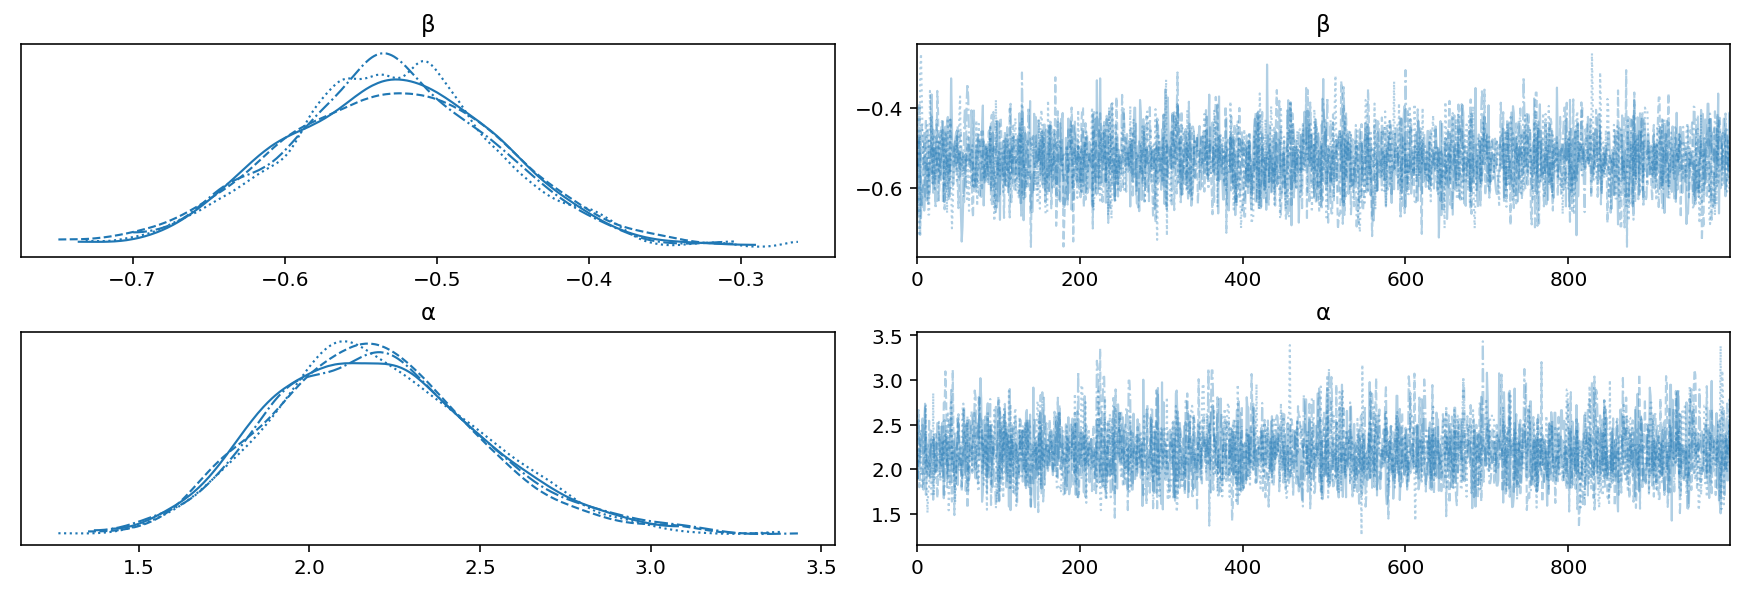

In [13]:
az.plot_trace(sim1_trace, var_names=["β", "α"]);

In [14]:
az.summary(sim1_trace, var_names=["α", "β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.194,0.306,1.671,2.802,0.005,0.004,3471.0,2534.0,1.0
β,-0.530,0.070,-0.656,-0.395,0.001,0.001,3482.0,2892.0,1.0


## Simulation 2. Multiple sgRNA

---

In [15]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.81 minutes


In [16]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-09-08

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: nb-model

arviz     : 0.11.2
numpy     : 1.21.2
seaborn   : 0.11.2
scipy     : 1.7.1
plotnine  : 0.8.0
pymc3     : 3.11.2
pandas    : 1.3.2
theano    : 1.0.5
re        : 2.2.1
matplotlib: 3.4.3

